# Lending Club Dataset - Predicting the Default
Author: Michał Siwek, Date: May 19, 2017

## Introduction
### Goal of the Analysis
This is a predictive analysis of the Lending Club dataset at Kaggle. The goal is to **predict Default** using other available features. The notebook covers **two approaches**:

1. Use **all available features**. It gives high accuracy but the downside is that some of the features directly reveal the status of the loan (e.g. positive recoveries indicate a default), so the resulting model has no value for decision making.

2. Use **all features available at a moment of credit application submission**. This approach is relevant for a real decision making situation - we have to decide if a particular credit will end up in default or not, given only the application information. The downside of this approach is that we have to drop many features and observations as irrelevant and thus make the prediction harder.

To limit computational time the notebook does not contain hyperparameter tuning. For the same reason ensemble models include low number of base estimators. If you want to see hyperparameter tuning please see e.g. this [short notebook](https://github.com/ibah/kaggle-leaf-classification/blob/master/mLeaf3.ipynb) covering another of Kaggle's datasets.

### Dataset
Lending Club is an online platform connecting borrowers and lenders. The dataset covers complete data on loans issued in years 2007-2015. There are around 890,000 observations for 75 variables. ** *'loan status'* variable indicates default** if it has one of the following values:

* 'Charged Off'
* 'Default'
* 'Does not meet the credit policy. Status:Charged Off'
* 'Late (31-120 days)'

Otherwise the credit hasn't defaulted.

### Results
Depending on the approach we arrive at much different conclusions.

When utilizing all available features (**approach I**) we easily select a **well performing random forest model** (over 99% accuracy) against AdaBoost and LDA models.

When constrained to use only a subset of features (**approach II**) we arrive at a model that offers much lower accuracy (78%) and very low recall (8%). If we want to use this model to specifically avoid accepting defaulting credits then we can adjust the probability cutoff to get **50% recall at the cost of 23% false positive rate**. The analysis also contains suggestions of **next steps** that can be taken to increase prediction quality.

## Data Loading and Preprocessing
Here we load the data, categorize the variables in terms of their relevance for modeling and their type, prepare preprocessing functions. Also we explore the dataset visually.

In [2]:
# Importing libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, LabelBinarizer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve, recall_score, precision_score
from sklearn.metrics import f1_score, fbeta_score
import warnings; warnings.filterwarnings('ignore')
%matplotlib inline
plt.rcParams['figure.figsize'] = [10,6]

In [3]:
# Loading data
data = pd.read_csv('../input/loan.csv')

We split the variables into 5 categories depending on their relevance for modeling:

* Identifiers, etc. (we won't use them as predictors)
* Features available at a moment of credit application submission
* Features describing an open credit
* Features available after closing a credit
* Response variable

In [4]:
# Identifiers
set_0 = ['id', 'member_id', 'url']

# Credit application
set_1 = ['loan_amnt', 'term', 'int_rate', 'installment', 'grade', 'sub_grade',
         'emp_title', 'emp_length', 'home_ownership', 'annual_inc',
         'verification_status', 'desc', 'purpose', 'title', 'zip_code',
         'addr_state', 'dti', 'delinq_2yrs', 'earliest_cr_line',
         'inq_last_6mths', 'mths_since_last_delinq', 'mths_since_last_record',
         'open_acc', 'pub_rec', 'total_acc', 'initial_list_status',
         'collections_12_mths_ex_med', 'mths_since_last_major_derog',
         'policy_code', 'application_type', 'annual_inc_joint', 'dti_joint',
         'verification_status_joint', 'acc_now_delinq', 'tot_coll_amt',
         'tot_cur_bal', 'open_acc_6m', 'open_il_6m', 'open_il_12m',
         'open_il_24m', 'mths_since_rcnt_il',  'total_bal_il', 'il_util',
         'open_rv_12m', 'open_rv_24m', 'max_bal_bc', 'all_util',
         'total_rev_hi_lim', 'inq_fi', 'total_cu_tl', 'inq_last_12m']

# Open credit
set_2 = ['funded_amnt', 'funded_amnt_inv', 'issue_d', 'pymnt_plan',
         'revol_bal', 'revol_util', # revol_bal maybe available during the application
         'out_prncp', 'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv',
         'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee',
         'last_pymnt_d', 'last_pymnt_amnt', 'next_pymnt_d',
         'last_credit_pull_d']

# Closed credit
set_3 = ['recoveries', 'collection_recovery_fee']

# Response variable
set_y = ['loan_status']

The *loan_status* variable can take on 10 different values. However for our needs we will classify the loans into three categories:

* open/current credit
* repaid loan
* defaulted loan

In [5]:
statuses = data.loan_status.unique()
default = np.array(['Charged Off', 'Default',
                   'Does not meet the credit policy. Status:Charged Off',
                   'Late (31-120 days)'])
repaid = np.array(['Fully Paid',
                   'Does not meet the credit policy. Status:Fully Paid'])
current = np.array(['Current', 'In Grace Period', 'Late (16-30 days)',
                    'Issued'])

# Helper functions to handle statuses
def make_binary(y):
    '''
    Converts status description into a binary indicator 1/0 (default/non-default).
    '''
    return pd.Series(y).apply(lambda x: 1 if x in default else 0)

def make_binary_label(y):
    '''
    Converts status description into a binary label (Default/Non-default).
    '''
    return pd.Series(y).apply(lambda x: 'Default' if x in default else 'Non-default')

### Visual exploration

Let's take a look at the data to visualize distributions of and relationships between some of the important variables.

In [6]:
# Ensuring missing data is properly coded
data.replace('n/a', np.nan, inplace=True)

# Converting dates into proper format
tmp_index = data.index
issue_d = data.issue_d.apply(pd.to_datetime, format='%b-%Y')
last_pymnt_d = data.last_pymnt_d.apply(pd.to_datetime, format='%b-%Y')

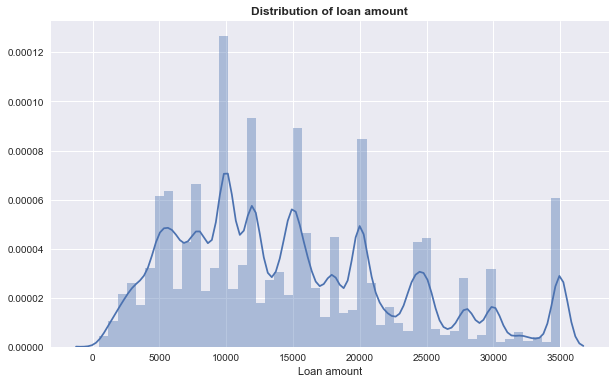

In [7]:
# Distribution of loan amount
sns.distplot(data.loan_amnt)
plt.title("Distribution of loan amount", fontweight='bold')
plt.xlabel("Loan amount")
plt.show()

This is the overall loan amount distribution. We can see some focal points located at round numbers.

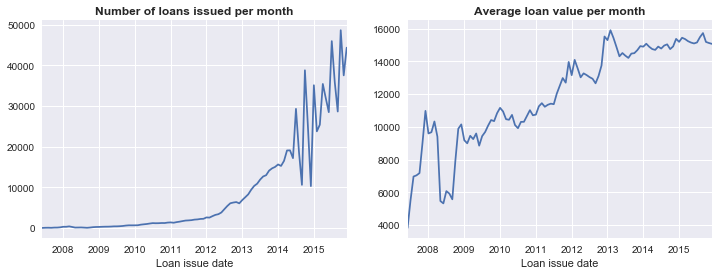

In [8]:
# Number and average value of loans over time
plt.figure(figsize=(12,4))
data.index = issue_d
loan_amnt_monthly = data.loan_amnt.groupby(pd.TimeGrouper(freq='M')).sum()
loan_count_monthly = data.loan_amnt.groupby(pd.TimeGrouper(freq='M')).count()
plt.subplot(121)
loan_count_monthly.plot()
plt.title("Number of loans issued per month", fontweight='bold')
plt.xlabel("Loan issue date")
plt.subplot(122)
loan_amnt_monthly.divide(loan_count_monthly).plot()
plt.title("Average loan value per month", fontweight='bold')
plt.xlabel("Loan issue date")
plt.show()

Number of loans issued per date **increases exponentially**. It means that **loans issued in the early period (say years 2007 - 2012) have little impact on the overall picture**. The average loan amount experience a rather steady increase. The fluctuations in years 2007 - 2009 have negligible effect due to the relatively low number of loans issued during that period.

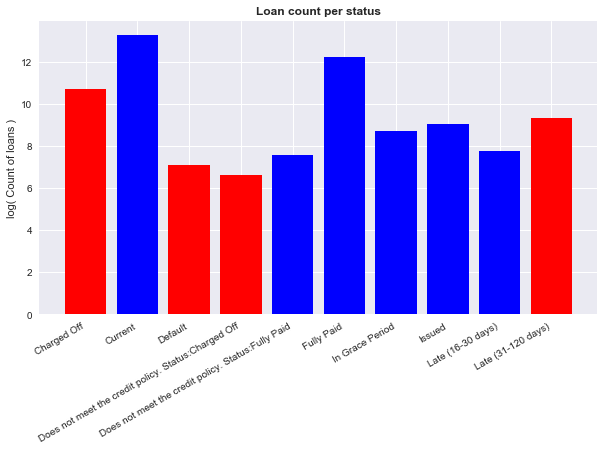

In [9]:
# Loan count per status
loan_count_per_status = data.groupby('loan_status').size()
loan_amnt_per_status = data.groupby('loan_status').loan_amnt.sum()
color = make_binary(loan_amnt_per_status.index).map({1:'r', 0:'b'})
fig, ax = plt.subplots(1)
ax.bar(range(10), np.log1p(loan_count_per_status), tick_label=loan_count_per_status.index, color = color)
plt.title('Loan count per status', fontweight='bold')
plt.ylabel("log( Count of loans )")
fig.autofmt_xdate()

There are big differences between counts of loans depending on their status. The above graph uses exponential y scale to adjust for it. We can see that the dataset consists mostly of *Current* and *Fully Paid* loans. **Defaults (indicated by red color) make up 7%** of all samples.

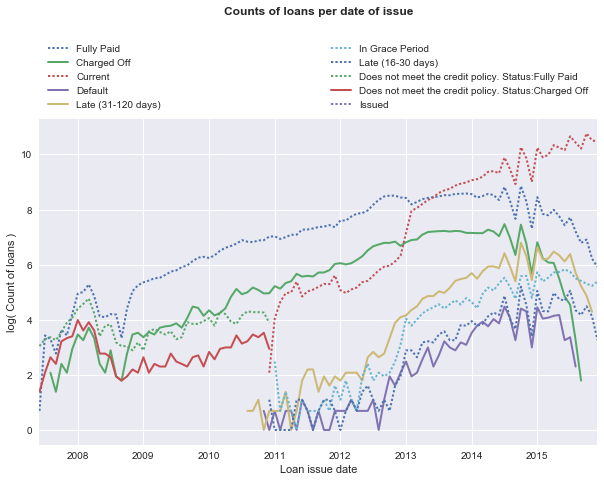

In [10]:
# Count of loans per date of issue
data.index = issue_d
for status in statuses:
    ls = '-' if status in default else ':'
    np.log1p(data[data.loan_status==status].
             groupby(pd.TimeGrouper(freq='M')).
             size()).plot(label=status, ls=ls, lw=2)
plt.legend(bbox_to_anchor=(0, 1, 1, 0), loc=3, ncol=2, mode="expand")
plt.title("Counts of loans per date of issue", y=1.3, fontweight='bold')
plt.ylabel("log( Count of loans )")
plt.xlabel("Loan issue date")
plt.show()

This figure shows counts of loans per date of issue again using exponential y scale. The solid lines indicate defaulted loans. It shows that **some policy change took place around Jan 1, 2011** - e.g. *'Does not meet...'* statuses cover only loans issued before that date. One could suggest that we should limit our analysis to the period after year 2010. I actually tried this while exploring approach II of this notebook, however it brought no real change for model quality as loans issued before 2011 are relatively very few.

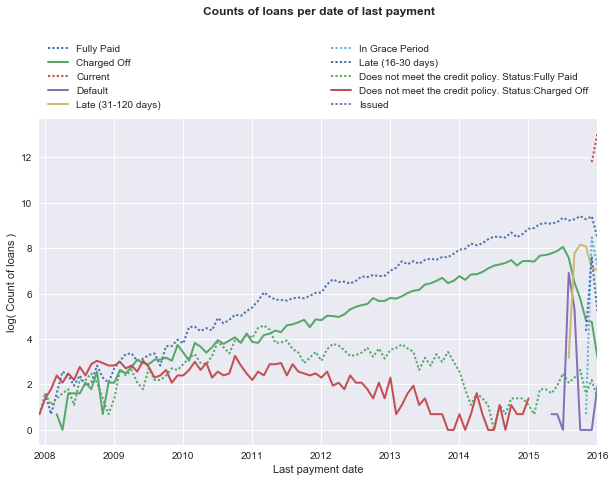

In [11]:
# Count of loans per date of last payment
data.index = last_pymnt_d
for status in statuses:
    ls = '-' if status in default else ':'
    np.log1p(data[data.loan_status==status].
             groupby(pd.TimeGrouper(freq='M')).
             size()).plot(label=status, ls=ls, lw=2)
plt.legend(bbox_to_anchor=(0, 1, 1, 0), loc=3, ncol=2, mode="expand")
plt.title("Counts of loans per date of last payment", y=1.3, fontweight='bold')
plt.ylabel("log( Count of loans )")
plt.xlabel("Last payment date")
plt.show()
# setting back the original data index
data.index = tmp_index

The date of the last payment is relevant for our analysis as **defaulting on a credit means the borrower stopped making payments**.

The above figure shows that *'Default'* and *'Late 31-120 days'* categories are used only for loans for which the payments stopped recently. The *'Does not meet...Charged Off'* category was apparently applicable only till the end of 2014, as there are no loans under that category that were still being repaid after 2014. The *'Charged Off'* category is being constantly used till the middle of 2015. I suppose the *'Default'* and *'Late...'* categories are applicable to loans that just got into troubles, but when after a few months it turns out the payments did not resume then the loans become *'Charged Off'*.

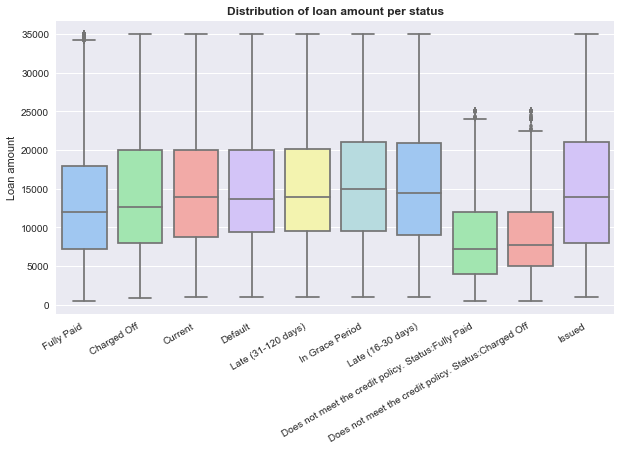

In [12]:
# Distribution of loan amount per status
fig, ax = plt.subplots(1)
sns.boxplot('loan_status', 'loan_amnt', data=data, palette='pastel')
plt.title("Distribution of loan amount per status", fontweight='bold')
plt.ylabel("Loan amount")
plt.xlabel("")
fig.autofmt_xdate()
plt.show()

There is not much to learn from the above figure than that loans issued in the past were on average lower in amount (see the *'Does not meet...'* categories) and that on average it is easier to pay off rather smaller than a bigger debt (see the *'Fully Paid'* category).

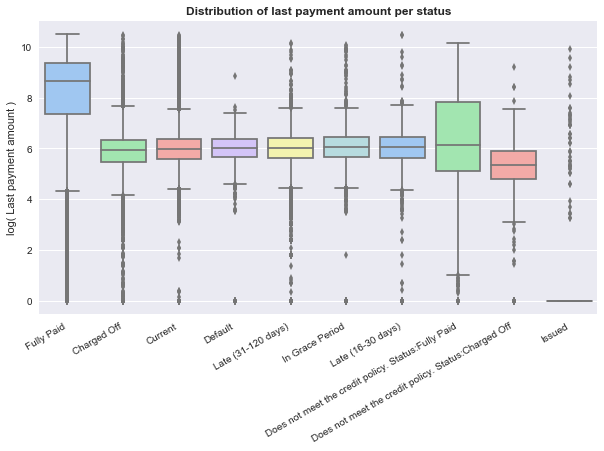

In [13]:
# Distribution of last payment amount per status
fig, ax = plt.subplots(1)
sns.boxplot(data.loan_status, np.log1p(data.last_pymnt_amnt), palette='pastel')
plt.title("Distribution of last payment amount per status", fontweight='bold')
plt.ylabel("log( Last payment amount )")
plt.xlabel("")
fig.autofmt_xdate()
plt.show()

This figure tells us that's the last payment (for fully paid loans) is usually a big one - probably borrowers tend to repay the loans before the final term and so the last payment aggregates several installments into one (note that the y scale here is exponential). So **a big payment usually means the loan is just being fully repaid**.

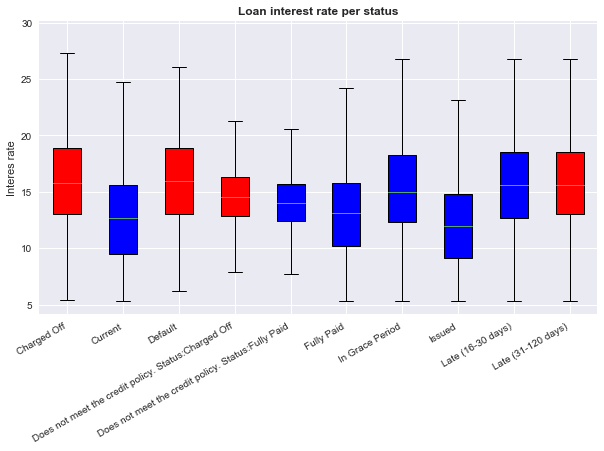

In [14]:
# Loan interest rate by status
plt_int_rate = data.groupby('loan_status').int_rate.apply(lambda x: x.values)
plt_colors = ['r','b','r','r','b','b','b','b','b','r']
fig, ax = plt.subplots(1)
box = ax.boxplot(plt_int_rate, labels=plt_int_rate.index, patch_artist=True)
for patch, color in zip(box['boxes'], plt_colors):
    patch.set_facecolor(color)
plt.title("Loan interest rate per status", fontweight='bold')
plt.ylabel("Interes rate")
fig.autofmt_xdate()
plt.show()

The last exploratory plot shows us that **the defaulted loans (shown in red) on average have higher interest rate** assigned by Lending Club than the non-defaulted loans (shown in blue).

### Preprocessing of Predictors

We will **group variables by the type of preprocessing** required for the model training. Also we will define a function that will do the preprocessing. We will **drop following variables**:
* *'id','member_id','url'* - these are identifiers that we don't want to use in learning
* *'emp_title', 'desc', 'title'* - these are potentially useful variables that require additional text analysis (e.g. key word search or some kind of standardization), moreover *'title'* has a proxy variable *'purpose'*
* *'zip_code'* - this variable is computationally expensive to include without some aggregation, so we leave it out for now

In [15]:
# Features per type of preprocessing required

# drop
drop = ['id','member_id','url','emp_title','desc','title','zip_code']

# convert to datetime
date = ['earliest_cr_line', 'last_credit_pull_d', 'issue_d',
        'last_pymnt_d', 'next_pymnt_d']

# convert into dummies
dummy = ['addr_state', 'purpose', 'emp_length', 'grade',
         'home_ownership', 'verification_status_joint',
         'verification_status', 'pymnt_plan', 'application_type',
         'initial_list_status', 'term']

# apply calcuations
calculate = ['sub_grade']

# response variable
response = ['loan_status']

# numeric variables
numeric = [x for x in data.columns if x not in drop + date + dummy + calculate + response]

# Preprocessing function for transforming predictors into scikit-learn model inputs
def transform_predictors(raw_data):
    """
    Preprocessing for predictors
    
    Transforms predictors into a form suitable for scikit-learn models input:
    date variables -> pd.DateTime -> np.int64
    categorical variables -> dummies (one-hot encoding)
    sub_grade variable (A1, B2 etc.) -> numerical preserving ordering
    np.NaN -> -99
    
    Parameters
    ----------
    raw_data : pd.DataFrame
        any subset of of features/samples from the original dataset
    
    Returns
    -------
    pd.DataFrame
        predictors ready to be fed into scikit-learn models
    """
    
    # Date columns
    columns = np.intersect1d(date, raw_data.columns)
    date_columns = raw_data[columns].apply(
            pd.to_datetime, format='%b-%Y').astype(np.int64)
    date_columns = date_columns.apply(
            lambda column: column.apply(lambda x: -99 if x < 0 else x))
    
    # Categorical columns
    columns = np.intersect1d(dummy, raw_data.columns)
    dummy_columns = pd.get_dummies(raw_data[columns])
    
    # Calculated columns
    calculated_columns = raw_data.sub_grade.apply(
            lambda x: (ord(x[0])-65)*5+int(x[1]))
    columns = np.intersect1d(numeric, raw_data.columns)
    numeric_columns = raw_data[columns]
    X = pd.concat([date_columns, dummy_columns, calculated_columns,
                   numeric_columns], axis=1)
    
    # Dealing with missing values
    X.fillna(-99, inplace=True)
    
    return X

### Preprocessing of the Response Variable
The response variable represents 10 classes that are aggregated into two categories: Default and Non-default. We will process this variable in two ways so that we can both perform binary and multiclass classification, depending on our choice. We will generate:

* y_binary - a binary response
* y_multi - a multiclass response

To facilitate translations from labels into one-hot encoding we create a scikit-learn pipeline.

In [16]:
# Encoder from labels to integers
class CustomEncoder():
    """
    This is a wrapper for LabelEncoder so that it can be used in a pipeline
    """
    def __init__(self):
        self.le = LabelEncoder()
        
    def fit(self, y):
        self.le.fit(y)
        
    def transform(self, y):
        return self.le.transform(y).reshape(-1,1)

    def fit_transform(self, X, y=None):
        self.fit(X)
        return self.transform(X)
    
    def inverse_transform(self, y):
        return self.le.inverse_transform(y)

# Function returning multiclass y and a transformer pipeline
def make_multiclass(raw_y):
    """
    Returns
    -------
    np.array
        one-hot encoded response variable
    sklearn.pipeline.Pipeline
        a pipeline transforming multiple labels into one-hot encoding (and reverse)
    """
    response_pipe = make_pipeline(CustomEncoder(), LabelBinarizer())
    y_multi = response_pipe.fit_transform(raw_y)
    return y_multi, response_pipe

## Modeling Approach I (full dataset)
Here we **use all available features to predict the default**. We take following steps:

1. Preprocess the data
2. Split data into training and test set, set up cross validation schema
3. Train and evaluate three models:
  1. Linear Discriminant Analysis
  2. AdaBoost
  3. Random Forest
4. Draw conclusions and evaluate models on the test set

**Evaluation** is done using accuracy and recall scores, also confusion matrix. ROC and AUC are calculated using the test set.

### Preprocessing

In [17]:
# Preprocessing predictors and response
X = transform_predictors(data)
n_samples, n_features = X.shape
y_binary = make_binary(data.loan_status)
y_multi, y_transformer = make_multiclass(data.loan_status)

### Validation and Testing
We randomly split the dataset into **training (70%) and test (30%) sets**. Training set is used to train the models and evaluate them by cross-validation. We use **StratifiedKFold cross-validation** that preserves percentages of samples for each class in the folds. The **test set is hold out** during the evaluation phase and is used to estimate generalization error. The goal of this setup is to avoid overfitting to the test set due to using it for model selection.

In [18]:
# Selecting target y
y = y_binary

# Test-Train split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)
n_train = y_train.shape[0]
n_test = y_test.shape[0]

# Cross validation - will be used to evaluate the models using train data
skf = StratifiedKFold(n_splits=3, random_state=234)

**Null classifier** predicts always Non-default (the dominant status) and so provides a basic reference level for prediction accuracy. Our models should outperform the null classifier.

In [19]:
# Reference Evaluation Measure
null_prediction = np.zeros(y_train.size)
print("Null classifier accuracy score: %0.4f" % accuracy_score(y_train, null_prediction))

Null classifier accuracy score: 0.9337


### Linear Discriminant Analysis
This is a basic model for binary and multiclass classification. This model standardizes the predictors internally so there's no need to standardize them explicitly.

Many of the predictors have skewed distributions. This may cause a problem as it violates LDA's assumptions. I ran this model separately with first correcting the skewness but it did not improve the performance.

In [20]:
# Setting up the model
lda = LinearDiscriminantAnalysis()

# Fitting
lda.fit(X_train, y_train)

LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
              solver='svd', store_covariance=False, tol=0.0001)

In [21]:
# Evaluation
lda_cv_pred = cross_val_predict(lda, X_train, y_train, cv=skf, n_jobs=2)

In [22]:
# Preformance measures
print(("Accuracy: %.4f\n" % accuracy_score(y_train, lda_cv_pred)))
print(("Recall score: %.4f\n" % recall_score(y_train, lda_cv_pred)))
print("Confusion matrix:")
print(confusion_matrix(y_train, lda_cv_pred))
print("\nColumns: predicted non-default/default")
print("Rows: true non-default/default")

Accuracy: 0.9747

Recall score: 0.6270

Confusion matrix:
[[579640    345]
 [ 15359  25821]]

Columns: predicted non-default/default
Rows: true non-default/default


### AdaBoost
We use small number of base estimators to reduce computation time.

In [23]:
# Setting up the model
ab = AdaBoostClassifier(n_estimators=20, random_state=123)

# Fitting
ab.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=20, random_state=123)

In [24]:
# Evaluation
ab_cv_pred = cross_val_predict(ab, X_train, y_train, cv=skf, n_jobs=2)

In [25]:
# Preformance measures
print(("Accuracy: %.4f\n" % accuracy_score(y_train, ab_cv_pred)))
print(("Recall score: %.4f\n" % recall_score(y_train, ab_cv_pred)))
print("Confusion matrix:")
print(confusion_matrix(y_train, ab_cv_pred))
print("\nColumns: predicted non-default/default")
print("Rows: true non-default/default")

Accuracy: 0.9886

Recall score: 0.8695

Confusion matrix:
[[578272   1713]
 [  5375  35805]]

Columns: predicted non-default/default
Rows: true non-default/default


### Random Forest
Random Forest is faster than AdaBoost so we will use 50 estimators.

In [26]:
# Setting up the model
rf = RandomForestClassifier(n_estimators=50,
                             min_samples_split=10,
                             min_samples_leaf=1,
                             max_features='auto',
                             oob_score=True,
                             random_state=345,
                             n_jobs=2)

# Fitting
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=10, min_weight_fraction_leaf=0.0,
            n_estimators=50, n_jobs=2, oob_score=True, random_state=345,
            verbose=0, warm_start=False)

In [27]:
# Evaluation
print("Generalization accuracy score calculated during the training: %.4f" % rf.oob_score_)
rf_cv_pred = cross_val_predict(rf, X_train, y_train, cv=skf, n_jobs=2)

Generalization accuracy score calculated during the training: 0.9961


In [28]:
# Preformance measures
print(("Accuracy: %.4f\n" % accuracy_score(y_train, rf_cv_pred)))
print(("Recall score: %.4f\n" % recall_score(y_train, rf_cv_pred)))
print("Confusion matrix:")
print(confusion_matrix(y_train, rf_cv_pred))
print("\nColumns: predicted non-default/default")
print("Rows: true non-default/default")

Accuracy: 0.9960

Recall score: 0.9412

Confusion matrix:
[[579925     60]
 [  2422  38758]]

Columns: predicted non-default/default
Rows: true non-default/default


### Model Selection
Based on the performance measures (accuracy and recall) there's a strict preference relation between models:

LDA < AdaBoost < Random Forest

We select **Random Forest** as it achieves best performance both for accuracy and recall. **Recall** is of special importance as it shows what share of actual defaults is correctly predicted by the model. We may assume that we want to avoid wrongly classified defaults more than wrongly classified non-defaulting credits.

Below we estimate the **generalization error**, plot **ROC curves** and calculate **AUC** for the models using the test set.

In [29]:
# Prediction on the test set
lda_pred = lda.predict(X_test)
ab_pred = ab.predict(X_test)
rf_pred = rf.predict(X_test)
lda_pred_proba = lda.predict_proba(X_test)
ab_pred_proba = ab.predict_proba(X_test)
rf_pred_proba = rf.predict_proba(X_test)

In [30]:
# Accuracy on the test set
print("Accuracy scores on the test set:")
print(("LDA: %.4f" % accuracy_score(y_test, lda_pred)))
print(("AdaBoost: %.4f" % accuracy_score(y_test, ab_pred)))
print(("Random Forest: %.4f" % accuracy_score(y_test, rf_pred)))
print("")
# Recall on the test set
print("Recall scores on the test set:")
print(("LDA: %.4f" % recall_score(y_test, lda_pred)))
print(("AdaBoost: %.4f" % recall_score(y_test, ab_pred)))
print(("Random Forest: %.4f" % recall_score(y_test, rf_pred)))

Accuracy scores on the test set:
LDA: 0.9747
AdaBoost: 0.9889
Random Forest: 0.9962

Recall scores on the test set:
LDA: 0.6264
AdaBoost: 0.8775
Random Forest: 0.9438


In [31]:
# ROC curves and AUC
y_score = {'LDA': lda_pred_proba[:,1],
           'AB': ab_pred_proba[:,1],
           'RF': rf_pred_proba[:,1]}

In [32]:
fpr = dict()
tpr = dict()
roc_auc = dict()
for m in y_score:
    fpr[m], tpr[m], _ = roc_curve(y_test, y_score[m])
    roc_auc[m] = auc(fpr[m], tpr[m])

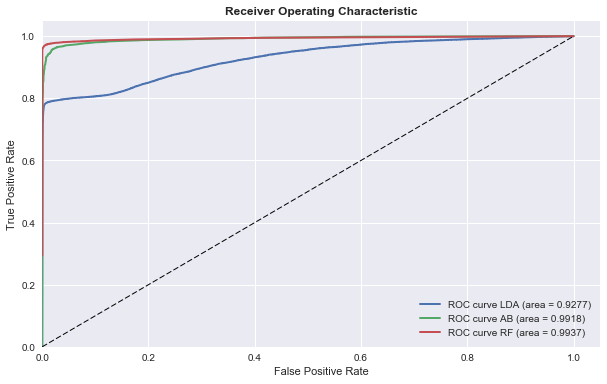

In [33]:
plt.figure()
for m in ['LDA','AB','RF']:
    plt.plot(fpr[m], tpr[m], lw=2,
         label='ROC curve %s (area = %0.4f)' % (m, roc_auc[m]))
plt.plot([0, 1], [0, 1], color='black', lw=1, linestyle='--')
plt.xlim([0.0, 1.05])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic', fontweight='bold')
plt.legend(loc="lower right")
plt.show()

ROC Curves and AUC for ROC confirms the ordering of the models and **high predictive quality of the random forest model**.

### Conclusions of Modeling Approach I
The random forest model performance could be improved by increasing the number of base estimators. Also we could tune the hyperparameters using grid search. Still its performance is very high: **99.6% accuracy and 94% recall**.

Let's take a look at **the most important variables for predicting default** according to our model:

In [34]:
rf_feature_importance = pd.DataFrame(
        rf.feature_importances_, index=X_train.columns, columns=['Importance'])
rf_feature_importance.sort_values(by='Importance', ascending=False)[:10]

,Importance
last_pymnt_d,0.152286
collection_recovery_fee,0.131296
recoveries,0.122555
total_rec_prncp,0.091938
last_pymnt_amnt,0.069198
total_pymnt,0.051221
next_pymnt_d,0.037576
total_pymnt_inv,0.036133
out_prncp_inv,0.033631
funded_amnt,0.029085


We see that all top predictors are available **only after the loan was actually granted**. Moreover some of the predictors have non-zero value **only after actual default takes place**:

In [35]:
# collection recovery fee
data[data.collection_recovery_fee>0].loan_status.unique()

array(['Charged Off', 'Does not meet the credit policy. Status:Charged Off'], dtype=object)

In [36]:
# recoveries - post charge off gross recoverydata[data.recoveries>0].loan_status.unique()

This shows that our model, though well performing, has **no relevance for decision making**.

## Modeling Approach II (subsetting the dataset)
Here we select **features that are available at a moment of credit application submission** so that the predictive model can serve as support for decision making by indicating whether or not one should expect default if the loan was granted.


We take following steps:

1. Preprocess the data (including feature and sample selection)
2. Split data into training and test set, set up cross validation schema
3. Train and evaluate two models:
  1. Random Forest for binary classification
  2. Random Forest for multiclass classification with sample weights
4. Draw conclusions and evaluate model on the test set

**Evaluation** is done using accuracy and recall scores, also confusion matrix. ROC and AUC will be calculated using the test set.

### Preprocessing
We subset the data by selecting **only relevant columns and rows**:

* relevant columns - features available on credit application submission
* relevant rows - observations of closed credits only i.e. either defaulted or fully paid off loans

In [37]:
# Selecting relevant features and observations
sub_data = data[np.hstack([set_1, set_y])]
sub_data = sub_data[sub_data.loan_status.isin(np.hstack([default,repaid]))]

In [38]:
# Preprocessing predictors and response
X = transform_predictors(sub_data)
n_samples, n_features = X.shape
y_binary = make_binary(sub_data.loan_status)
y_multi, y_transformer = make_multiclass(sub_data.loan_status)

### Validation and Testing
Exactly as in Approach I:

*We randomly split the dataset into **training (70%) and test (30%) sets**. Training set is used to train the models and evaluate them by cross-validation. We use **StratifiedKFold cross-validation** that preserves percentages of samples for each class in the folds. The **test set is hold out** during the evaluation phase and is used to estimate generalization error. The goal of this setup is to avoid overfitting to the test set due to using it for model selection.*

In [39]:
# Selecting target y
y = y_binary

# Test-Train split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)
n_train = y_train.shape[0]
n_test = y_test.shape[0]

# Cross validation - will be used to evaluate the models using train data
skf = StratifiedKFold(n_splits=3, random_state=234)

**Null classifier** (predicting always non-default) provides a basic reference level for prediction accuracy. Our model should outperform the null classifier.

In [40]:
# Reference Evaluation Measure
null_prediction = np.zeros(y_train.size)
print("Null classifier accuracy score: %0.4f" % accuracy_score(y_train, null_prediction))

Null classifier accuracy score: 0.7810


### Random Forest (binary response)
Random forest model trained on a subset of data and with a binary response.

In [41]:
# Setting up the model
sub_rf = RandomForestClassifier(n_estimators=50,
                             min_samples_split=20,
                             min_samples_leaf=1,
                             max_features='auto',
                             oob_score=True,
                             random_state=345,
                             n_jobs=2)

# Fitting
sub_rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=20, min_weight_fraction_leaf=0.0,
            n_estimators=50, n_jobs=2, oob_score=True, random_state=345,
            verbose=0, warm_start=False)

In [42]:
# Evaluation
print("Generalization accuracy score calculated during the training: %.4f" % sub_rf.oob_score_)
sub_rf_cv_pred = cross_val_predict(sub_rf, X_train, y_train, cv=skf, n_jobs=2)

Generalization accuracy score calculated during the training: 0.7823


In [43]:
# Preformance measures
print(("Accuracy: %.4f\n" % accuracy_score(y_train, sub_rf_cv_pred)))
print(("Recall score: %.4f\n" % recall_score(y_train, sub_rf_cv_pred)))
print("Confusion matrix:")
print(confusion_matrix(y_train, sub_rf_cv_pred))
print("\nColumns: predicted non-default/default")
print("Rows: true non-default/default")

Accuracy: 0.7842

Recall score: 0.0806

Confusion matrix:
[[144092   2719]
 [ 37843   3317]]

Columns: predicted non-default/default
Rows: true non-default/default


The accuracy of 0.7842 presents only a small improvement comparing to the null classifier (accuracy of 0.7810). Furthermore the recall is very low, just 8%. It shows that after reformulating the **problem became much harder**.

We can diagnose our model using the **learning curve**.

In [44]:
# Learning curve
train_sizes, train_scores, valid_scores = learning_curve(
        sub_rf, X_train, y_train, cv=skf)

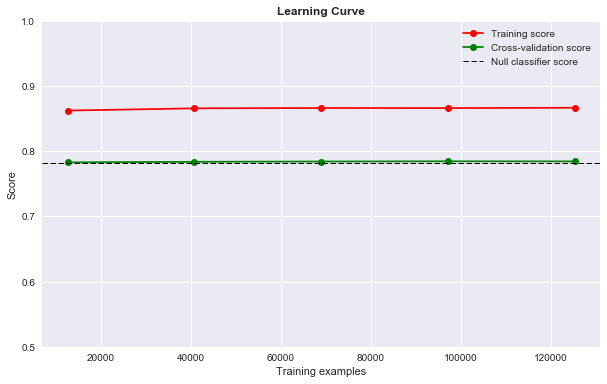

In [45]:
# Plotting the learning Curve
train_scores_mean = train_scores.mean(axis=1)
test_scores_mean = valid_scores.mean(axis=1)
plt.figure()
plt.ylim((.5,1))
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
plt.axhline(y=0.781, color='black', lw=1, linestyle='--', label="Null classifier score")
plt.title("Learning Curve", fontweight='bold')
plt.xlabel("Training examples")
plt.ylabel("Score")
plt.legend(loc="best")
plt.show()

The plot shows that our model **does not improve even if we feed more observations into it**.

The **CV accuracy is very low**, only slightly better than for the null classifier and the **learning curves are flat**. This indicates a high bias problem. There might be several reasons for this:

* the model is not flexible enough - we could add more trees to the forest or use more flexible model; I tested that adding more trees improves the cross validation accuracy, however to improvement is small.
* we do not have enough features - we could add potentially relevant features by extracting information from some unused variables (*emp_title, desc, title, zip_code*).
* the problem itself is hard - it is a possibility that there is not enough information in the data to made accurate predictions.

There is also a **persistent gap between the learning curves** which indicates a problem with variance. We could try tackle this by e.g. removing unimportant variables to reduce overfitting, try to modify random forest parameters to reduce its variance or use some other model with a better control for regularization.

Another possible path is to perform the **error analysis** - try to identify the most difficult groups of cases to predict. Below we build a multiclass model that can be used to check if among the few statuses that comprise the general default status there are some that are more difficult to predict.

### Random Forest (multiclass response)
This is a model created mostly for diagnostic reasons. It can be used to ascertain **prediction quality for different base classes that comprise the Default class**. Additionally it includes **sample weights** that are meant to direct the model training towards the Default cases.

We start with changing the setup of train and test set to **include the multiclass response**.

In [46]:
# Selecting new target y
y, y_pipe = make_multiclass(sub_data.loan_status)

# Test-Train split
X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=123)
n_train = y_train.shape[0]
n_test = y_test.shape[0]

# Cross validation
skf = StratifiedKFold(n_splits=3, random_state=234)

Setting up the model and sample weights. The default cases will be **5 times more important** than the non-default cases.

In [47]:
# Setting up the model
multi_sub_rf = RandomForestClassifier(n_estimators=50,
                             min_samples_split=20,
                             min_samples_leaf=1,
                             max_features='auto',
                             random_state=345,
                             n_jobs=2)

# Defining weights for samples
weights = 4 * y_train[:,[0,1,2,5]].sum(1) + 1

# Fitting
multi_sub_rf.fit(X_train, y_train, weights)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=20, min_weight_fraction_leaf=0.0,
            n_estimators=50, n_jobs=2, oob_score=False, random_state=345,
            verbose=0, warm_start=False)

We limit the analysis of this model to checking its **performance on the test set**.

In [48]:
# Predictions for the test set
multi_sub_rf_pred = multi_sub_rf.predict(X_test)
multi_sub_rf_pred_binary = make_binary(y_pipe.inverse_transform(multi_sub_rf_pred))
resp_binary = make_binary(y_pipe.inverse_transform(y_test))

In [49]:
# Preformance on the test set
print(("Accuracy: %.4f\n" % accuracy_score(resp_binary, multi_sub_rf_pred_binary)))
print(("Recall score: %.4f\n" % recall_score(resp_binary, multi_sub_rf_pred_binary)))
print(("Precision score: %.4f\n" % precision_score(resp_binary, multi_sub_rf_pred_binary)))
print("Confusion matrix:")
print(confusion_matrix(resp_binary, multi_sub_rf_pred_binary))
print("\nColumns: predicted non-default/default")
print("Rows: true non-default/default")

Accuracy: 0.7045

Recall score: 0.5304

Precision score: 0.3765

Confusion matrix:
[[47390 15510]
 [ 8292  9367]]

Columns: predicted non-default/default
Rows: true non-default/default


Applying sample weights decreased the accuracy (just 70% comparing with 78% for the previous model) but significantly increased recall (53% comparing with 8%).

### Conclusions for the Modeling Approach II
The performance of the random forest model for binary classification is not satisfactory due to low accuracy and recall. This prediction problem **requires more work and research**. Some possible actions to take are listed within the analysis of the model, they include adding new features and applying more flexible models.

In this section we **analyze the model using the test set**:

* performance measures
* ROC curve
* Precision-Recall curve

and suggest using the precision-recall trade-off to make the model focus on **avoiding bad loans**. We also check **which features play most important role** in predicting default.

In [50]:
# Predictions for the test set
sub_rf_pred = sub_rf.predict(X_test)
sub_rf_pred_proba = sub_rf.predict_proba(X_test)
y_test = resp_binary

In [51]:
# Preformance on the test set
print(("Accuracy: %.4f\n" % accuracy_score(y_test, sub_rf_pred)))
print(("Recall score: %.4f\n" % recall_score(y_test, sub_rf_pred)))
print("Confusion matrix:")
print(confusion_matrix(y_test, sub_rf_pred))
print("\nColumns: predicted non-default/default")
print("Rows: true non-default/default")

Accuracy: 0.7827

Recall score: 0.0802

Confusion matrix:
[[61634  1266]
 [16242  1417]]

Columns: predicted non-default/default
Rows: true non-default/default


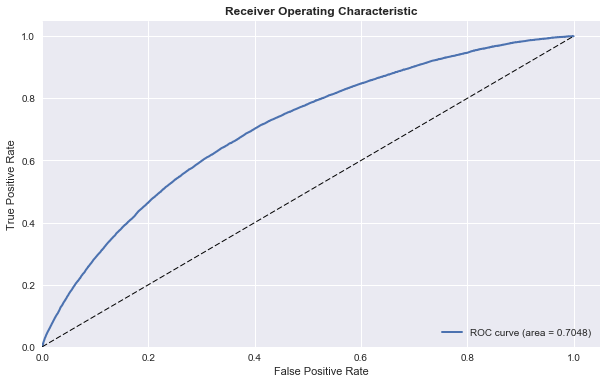

In [52]:
# ROC curve
y_score = sub_rf_pred_proba[:,1]
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, lw=2, label='ROC curve (area = %0.4f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='black', lw=1, linestyle='--')
plt.xlim([0.0, 1.05])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic', fontweight='bold')
plt.legend(loc="lower right")
plt.show()

The low recall of 8% means that with the standard 50% probability threshold our model as a prediction tool is located close to the bottom-left end of the ROC curve, within a small distance from the diagonal no-discrimination line. We should consider **lowering the probability threshold** so that we move towards the middle of the ROC plot where the performance differ more from a random guess. This is desirable also due to the fact that when predicting loan status we usually care more for correctly recognizing future defaults than non-defaults as avoiding the former is the main goal.

The **ROC Curve** shows us how we can increase the share of defaults that we correctly predict (True Positive Rate or Recall) at the cost of increasing the share of good non-defaulting loans that we wrongly classify as defaults. E.g. we can **recognize 50% of all defaults at the cost of losing 23% of non-defaulting credits** due to wrong classification.

We can also look at the **precision-recall plot**. It shows how we can increase the recall at the cost of lowering precision (i.e. increasing the share of good non-defaulting loans among those that we classify as defaults).

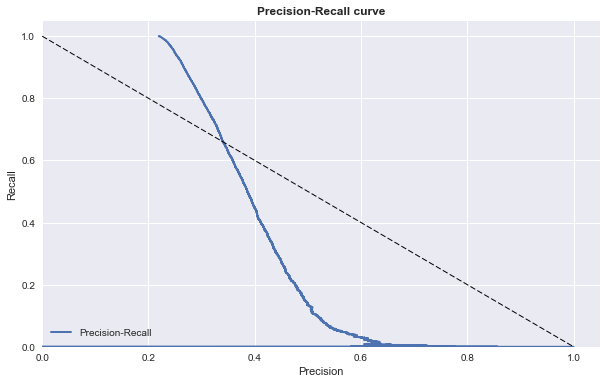

In [53]:
# Precision and Recall curve
precision, recall, tresholds = precision_recall_curve(y_test, y_score)
rec = recall_score(y_test, sub_rf_pred)
plt.figure()
plt.plot(precision, recall, lw=2, label='Precision-Recall')
plt.plot([0, 1], [1, 0], color='black', lw=1, linestyle='--')
plt.xlim([0.0, 1.05])
plt.ylim([0.0, 1.05])
plt.xlabel('Precision')
plt.ylabel('Recall')
plt.title('Precision-Recall curve', fontweight='bold')
plt.legend(loc="lower left")
plt.show()

**Lowering the threshold to 0.29** allows as to identify 50% of all defaults with 39% precision and 23% false positive rate.

In [54]:
# Setting the probability threshold to achieve 50% recall
threshold = 0.29
tuned_pred =  y_score > threshold
print("Recall: %0.4f, Precision: %0.4f, False Positive Rate: %0.4f" % (
    recall_score(y_test, tuned_pred),
    precision_score(y_test, tuned_pred),
    confusion_matrix(y_test, tuned_pred)[0,1] / confusion_matrix(y_test, tuned_pred)[0,:].sum()))

Recall: 0.5060, Precision: 0.3852, False Positive Rate: 0.2268


Let's take a look at the **variable importance**.

In [55]:
# Top important variables
sub_rf_feature_importance = pd.DataFrame(
        sub_rf.feature_importances_, index=X_train.columns, columns=['Importance'])
sub_rf_feature_importance.sort_values(by='Importance', ascending=False)[:10]

,Importance
int_rate,0.068934
dti,0.068600
annual_inc,0.060439
earliest_cr_line,0.053155
sub_grade,0.052385
installment,0.051764
total_rev_hi_lim,0.045622
tot_cur_bal,0.045538
loan_amnt,0.042545
total_acc,0.041247


The features of interest describe the client applying for credit or the loan itself. Variables describing **the client**:

* ratio of monthly debt payments to monthly income of the client
* annual income of the client
* date of earliest credit line opening for the client
* total revolving credit limit
* total current balance
* total number of credit lines opened for the client

Variables describing **the loan**:

* interest rate for the loan set by the Lending Club
* subgrade assigned to the loan by Lending Club
* monthly installment amount of the loan
* amount of the loan

According to our model these features reveal most about the future of a credit application (will it end up in a default or not).

It is worth noting that **evaluations of the loan made by the Lending Club** (interest rate, subgrade) are very informative with this respect. Concerning the relevance of the interest rate one can claim that it has a self-fulfilling prophecy aspect as assigning a high rate makes a loan more difficult to pay off and thus increases the probability of a default. This however does not undermine its role as a valuable predictor.

## Summary
We created and evaluated models built within **two approaches**: modeling using all available features and modeling using only features available at a moment of credit application submission.

The former approach led to models of **high accuracy (over 99%) but with no use for decision making**.

The latter led to a **low-performing model (accuracy of 78%) but one that could by used for decision making** (e.g. by increasing the recall to 50% at a cost of lowering accuracy). We suggested **next steps** to be taken in order to improve the prediction quality.